## Description

`Dataset berisikan informasi mengenai perilaku penggunaan kartu kredit aktif selama 6 bulan terakhir dari sekitar 9000 pemegang kartu kredit`

## Objective

`Melakukan customer segementation kepada 9000 pemegang kartu kredit, yang nantinya akan diberikan diberikan kepada divisi marketing`

## Informasi Mengenai variabel:
#### Data set ini berisi 18 variabel, berikut penjelasan setiap variabelnya:

    - CUSTID : Identitas Pemegang Kartu Kredit / user (Kategorik)

    - BALANCE : Jumlah saldo (Dollar Amerika) yang tersisa di akun user untuk melakukan pembelian
    
    - BALANCEFREQUENCY : Seberapa sering Saldo diperbarui, skor antara 0 dan 1 (1 = sering diperbarui, 0 = tidak sering diperbarui)
    
    - PURCHASES : Jumlah transaksi yang dilakukan dari akun
    
    - ONEOFFPURCHASES : jumlah transaksi maksimum yang dilakukan secara kas atau kontan
    
    - INSTALLMENTSPURCHASES : Jumlah transaksi yang dilakukan secara cicilan
    
    - CASHADVANCE : Uang muka yang diberikan oleh user
    
    - PURCHASESFREQUENCY : Seberapa sering transaksi dilakukan, skor antara 0 dan 1 (1 = sering dibeli, 0 = tidak sering dibeli)
    
    - ONEOFFPURCHASESFREQUENCY : Seberapa sering transaksi terjadi dengan cara kas / kontan (1 = sering dibeli, 0 = tidak sering dibeli)
    
    - PURCHASESINSTALLMENTSFREQUENCY : Seberapa sering transaksi terjadi dengan cara cicilan (1 = sering dibeli, 0 = tidak sering dibeli)
    
    - CASHADVANCEFREQUENCY : Seberapa sering uang muka dibayar
    
    - CASHADVANCETRX : Jumlah transaksi yang dilakukan dengan pembayaran uang muka
    
    - PURCHASESTRX : Jumlah transaksi pembelian dilakukan
    
    - CREDITLIMIT : Limit kartu kredit user
    
    - PAYMENTS : Jumlah transaksi yang telah dilakukan oleh user
    
    - MINIMUM_PAYMENTS : Jumlah transaksi minumum yang dilakukan oleh user
    
    - PRCFULLPAYMENT : persentase pembayaran secara kas / kontan oleh user
    
    - TENURE : Tenor kartu kredit user

***

# 1. Import Library

In [1]:
# common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.cluster as cluster
import plotly.express as px

# preprocessing data 
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline

# model machine learning
from sklearn.cluster import KMeans,DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering

# ignore warning
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 2. Data Loading

In [2]:
# data loading
data    = pd.read_csv('data/CC_GENERAL.csv')

# data backup 
df      = data.copy()

df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
# melihat jumlah data
print('jumlah data :' , len(df))

#melihat jumlah data yang unik pada CUST_ID
print('jumlah data CUST_ID:' , df['CUST_ID'].nunique())


jumlah data : 8950
jumlah data CUST_ID: 8950


`jumlah data yang unik pada kolom CUST_ID dan jumlah total dataset sama, sehingga CUST_ID sebenarnya tidak memiliki data yang ganda dan tidak merepsentasikan suatu hal yang dapat digunakan kedepannya, sehingga akan dihapus`

In [4]:
df = df.drop('CUST_ID', axis= 1)

# 3. Exploratory Data Analysis

## 3.a Cek Distribusi dan Informasi

In [5]:
def plot1(col):
    fig = plt.figure()
    fig.set_size_inches(20, 2)
    fig.subplots_adjust(hspace=1, wspace=0.2)
    sns.histplot(df[col])
    

def skala(col, teks):
    
    tot = df[col].shape[0]
    freq = round(df[col],1).sort_values().value_counts()

    for i,unik in enumerate (freq, start=0):
        
        if freq.index[i] == 0.0:
            print(round(((freq[0.0]+freq[0.1]+freq[0.2])/df.shape[0])*100,2),'% user jarang (0.0 - 0.2) {}'.format(teks))
        
        if freq.index[i] == 0.3:
            print(round(((freq[0.4]+freq[0.3])/df.shape[0])*100,2),'% user terkadang (0.3 - 0.4) {}'.format(teks))
        
        if freq.index[i] == 0.5:
            print(round(((freq[0.6]+freq[0.5])/df.shape[0])*100,2),'% user seringkali (0.5 - 0.6) {}'.format(teks))
        
        if freq.index[i] == 0.7:
            print(round(((freq[0.7]+freq[0.8])/df.shape[0])*100,2),'% user biasanya (0.7 - 0.8) {}'.format(teks))
            
        if freq.index[i] == 0.9:
            print(round(((freq[0.9]+freq[1.0])/df.shape[0])*100,2),'% user sering (0.9 - 1.0) {}'.format(teks))
            

def skala1(col):
    
    tot = df[col].shape[0]
    freq = round(df[col],1).sort_values().value_counts().reset_index()

    for i,unik in enumerate (freq['index'], start=0):
        
        if freq['index'][i] == 0.0:
            print(round((freq[col][i]/df.shape[0])*100,2),'%  user belum melakukan pembayaran tagihan sama sekali')
        
        if freq['index'][i] == 0.1:
            print(round(((freq[col][i]+freq[col][i+1])/df.shape[0])*100,2),'%  user melakukan pembayaran tagihan sebesar 10% - 20%  dari total tagihan')
        
        if freq['index'][i] == 0.3:
            print(round(((freq[col][i]+freq[col][i+1])/df.shape[0])*100,2),'%  user melakukan pembayaran tagihan sebesar 30% - 40%  dari total tagihan')
        
        if freq['index'][i] == 0.5:
            print(round(((freq[col][i]+freq[col][i+1])/df.shape[0])*100,2),'%  user melakukan pembayaran tagihan sebesar 50% - 60%  dari total tagihan')
        
        if freq['index'][i] == 0.7:
            print(round(((freq[col][i]+freq[col][i+1])/df.shape[0])*100,2),'%  user melakukan pembayaran tagihan sebesar 70% - 80%  dari total tagihan')
            
        if freq['index'][i] == 0.9:
            print(round(((freq[col][i]+freq[col][i+1])/df.shape[0])*100,2),'%  user melakukan pembayaran tagihan sebesar 90% - 100%  dari total tagihan')

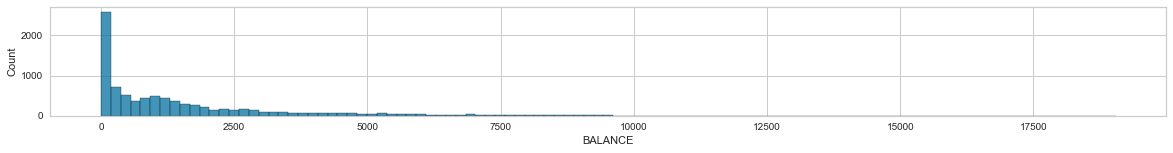

In [6]:
plot1('BALANCE')

In [7]:
df['BALANCE'].unique()

array([  40.900749, 3202.467416, 2495.148862, ...,   23.398673,
         13.457564,  372.708075])

In [8]:
print(round((df[df['BALANCE'] == 0].shape[0]/df.shape[0])*100,2), '% user tidak memiliki saldo tersisa ($0) di kartu kredit mereka')
print(round((df[(df['BALANCE'] > 0) &(df['BALANCE'] <= 2500)].shape[0]/df.shape[0])*100,2), '% user memiliki saldo tersisa sekitar $1 - $2500 di kartu kredit mereka')
print(round((df[(df['BALANCE'] > 2500) &(df['BALANCE'] <= 5000)].shape[0]/df.shape[0])*100,2), '% user memiliki saldo tersisa sekitar $2501 - $5000 di kartu kredit mereka')
print(round((df[(df['BALANCE'] > 5000) &(df['BALANCE'] <= 7500)].shape[0]/df.shape[0])*100,2), '% user memiliki saldo tersisa sekitar $5001 - $7500 di kartu kredit mereka')
print(round((df[(df['BALANCE'] > 7500)].shape[0]/df.shape[0])*100,2), '% user memiliki saldo tersisa diatas $7500 di kartu kredit mereka')

0.89 % user tidak memiliki saldo tersisa ($0) di kartu kredit mereka
78.45 % user memiliki saldo tersisa sekitar $1 - $2500 di kartu kredit mereka
13.04 % user memiliki saldo tersisa sekitar $2501 - $5000 di kartu kredit mereka
5.13 % user memiliki saldo tersisa sekitar $5001 - $7500 di kartu kredit mereka
2.49 % user memiliki saldo tersisa diatas $7500 di kartu kredit mereka


- `pada kolom BALANCE, distribusi datanya adalah skewed`

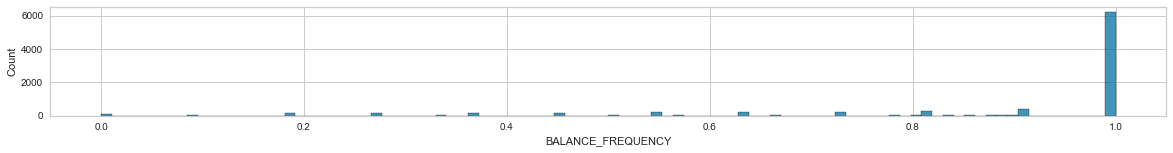

In [9]:
plot1('BALANCE_FREQUENCY')

In [10]:
skala('BALANCE_FREQUENCY', 'mengisi saldonya')

76.39 % user sering (0.9 - 1.0) mengisi saldonya
7.66 % user seringkali (0.5 - 0.6) mengisi saldonya
7.65 % user biasanya (0.7 - 0.8) mengisi saldonya
4.37 % user terkadang (0.3 - 0.4) mengisi saldonya
3.92 % user jarang (0.0 - 0.2) mengisi saldonya


- `pada kolom BALANCE_FREQUENCY, distribusi datanya adalah skewed`

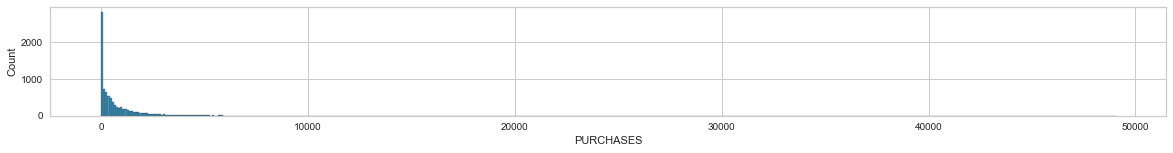

In [11]:
plot1('PURCHASES')

In [12]:
print(round(((df[(df['PURCHASES'] == 0)].shape[0]/df.shape[0]) - (df[(df['PURCHASES'] == 0) & (df['INSTALLMENTS_PURCHASES'] > 0)].shape[0]/df['PURCHASES'].shape[0]))*100,2),'% user selama 6 bulan terakhir tidak menggunakan kartu kreditnya')
print(round((df[(df['PURCHASES'] > 0) & (df['PURCHASES'] <= 2500)].shape[0]/df['PURCHASES'].shape[0])*100,2),'% user melakukan transaksi sekitar $1 hingga $2500 dalam 6 bulan terakhir')
print(round((df[(df['PURCHASES'] > 2500)].shape[0]/df['PURCHASES'].shape[0])*100,2),'% user melakukan transaksi lebih dari $2500 dalam 6 bulan terakhir')

22.82 % user selama 6 bulan terakhir tidak menggunakan kartu kreditnya
66.94 % user melakukan transaksi sekitar $1 hingga $2500 dalam 6 bulan terakhir
10.22 % user melakukan transaksi lebih dari $2500 dalam 6 bulan terakhir


In [13]:
tnp_trk      = df[(df['PURCHASES'] == 0)].shape[0]/df['PURCHASES'].shape[0]
tnp_trk_cil  = df[(df['PURCHASES'] == 0) & (df['INSTALLMENTS_PURCHASES'] > 0)].shape[0]/df['PURCHASES'].shape[0]
trk_kur_2500 = df[(df['PURCHASES'] > 0) & (df['PURCHASES'] <= 2500)].shape[0]/df['PURCHASES'].shape[0]
trk_leb_2500 = df[(df['PURCHASES'] > 2500)].shape[0]/df['PURCHASES'].shape[0]

print(round((tnp_trk)*100,2), '% user selama 6 bulan terakhir tidak menggunakan kartu kreditnya')
print(round((trk_kur_2500)*100,2), '% user melakukan transaksi sekitar $1 hingga $2500 dalam 6 bulan terakhir')
print(round(trk_leb_2500*100,2), '% user melakukan transaksi lebih dari $2500 dalam 6 bulan terakhir')

22.84 % user selama 6 bulan terakhir tidak menggunakan kartu kreditnya
66.94 % user melakukan transaksi sekitar $1 hingga $2500 dalam 6 bulan terakhir
10.22 % user melakukan transaksi lebih dari $2500 dalam 6 bulan terakhir


- `pada kolom PURCHASES, distribusi datanya adalah skewed`

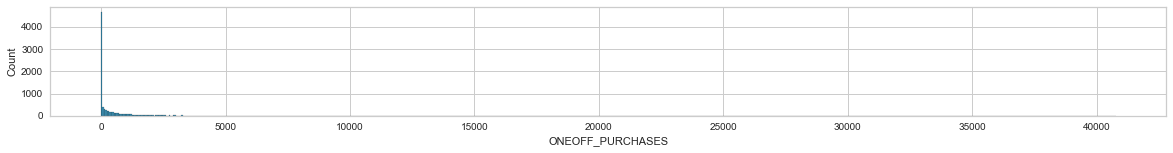

In [14]:
plot1('ONEOFF_PURCHASES')

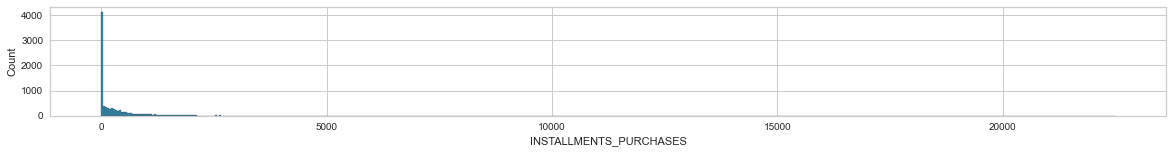

In [15]:
plot1('INSTALLMENTS_PURCHASES')

In [16]:
tip1= round((df[(df['ONEOFF_PURCHASES'] > 0) & (df['INSTALLMENTS_PURCHASES'] == 0)].shape[0]/df.shape[0])*100,2)
tip2= round((df[(df['ONEOFF_PURCHASES'] == 0) & (df['INSTALLMENTS_PURCHASES'] > 0)].shape[0]/df.shape[0])*100,2)
tip3= round((df[(df['ONEOFF_PURCHASES'] > 0) & (df['INSTALLMENTS_PURCHASES'] > 0)].shape[0]/df.shape[0])*100,2)
tip4= round((df[(df['ONEOFF_PURCHASES'] == 0) & (df['INSTALLMENTS_PURCHASES'] == 0)].shape[0]/df.shape[0])*100,2)

print(tip1,'% user melakukan transaksi hanya dengan metode kas/kontan tanpa melakukan cicilan')
print(tip2,'% user melakukan transaksi hanya dengan metode tanpa melakukan cicilan kas/kontan')
print(tip3,'% user melakukan transaksi dengan metode gabungan antara cicilan dan kas/kontan')
print(tip4,'% user melakukan tidak melakukan transaksi dengan metode gabungan antara cicilan dan kas/kontan')

20.94 % user melakukan transaksi hanya dengan metode kas/kontan tanpa melakukan cicilan
25.25 % user melakukan transaksi hanya dengan metode tanpa melakukan cicilan kas/kontan
30.99 % user melakukan transaksi dengan metode gabungan antara cicilan dan kas/kontan
22.82 % user melakukan tidak melakukan transaksi dengan metode gabungan antara cicilan dan kas/kontan


- `pada kolom ONEOFF_PURCHASES, distribusi datanya adalah skewed`
- `pada kolom INSTALLMENTS_PURCHASES, distribusi datanya adalah skewed`

In [17]:
dp = round((df[(df['CASH_ADVANCE'] == 0)].shape[0]/df.shape[0])*100,2)
print(dp,'% user melakukan transaksi dengan pembayaran dimuka (DP)')
print(100-dp,'% user melakukan transaksi dengan tanpa pembayaran dimuka (DP)')

51.71 % user melakukan transaksi dengan pembayaran dimuka (DP)
48.29 % user melakukan transaksi dengan tanpa pembayaran dimuka (DP)


- `pada kolom CASH_ADVANCE, distribusi datanya adalah skewed`

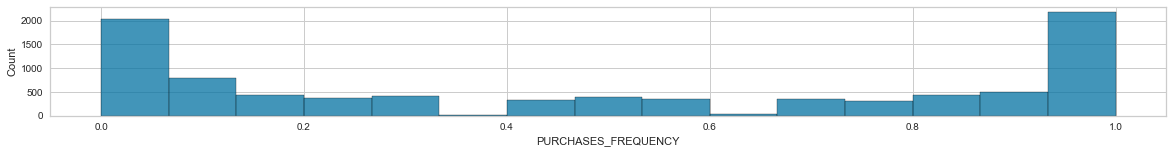

In [18]:
plot1('PURCHASES_FREQUENCY')

In [19]:
skala('PURCHASES_FREQUENCY','melakukan transaksi')

40.78 % user jarang (0.0 - 0.2) melakukan transaksi
30.11 % user sering (0.9 - 1.0) melakukan transaksi
9.04 % user seringkali (0.5 - 0.6) melakukan transaksi
8.26 % user terkadang (0.3 - 0.4) melakukan transaksi
11.81 % user biasanya (0.7 - 0.8) melakukan transaksi


- `pada kolom PURCHASES_FREQUENCY, datanya tidak terdistribusi normal`

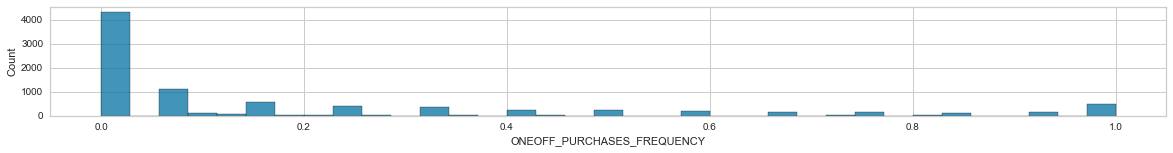

In [20]:
plot1('ONEOFF_PURCHASES_FREQUENCY')

In [21]:
skala('ONEOFF_PURCHASES_FREQUENCY', 'melakukan transaksi dengan metode kas / kontan')

74.73 % user jarang (0.0 - 0.2) melakukan transaksi dengan metode kas / kontan
7.5 % user terkadang (0.3 - 0.4) melakukan transaksi dengan metode kas / kontan
5.4 % user seringkali (0.5 - 0.6) melakukan transaksi dengan metode kas / kontan
5.16 % user biasanya (0.7 - 0.8) melakukan transaksi dengan metode kas / kontan
7.22 % user sering (0.9 - 1.0) melakukan transaksi dengan metode kas / kontan


- `pada kolom ONEOFF_PURCHASES_FREQUENCY, distribusi datanya adalah skewed`

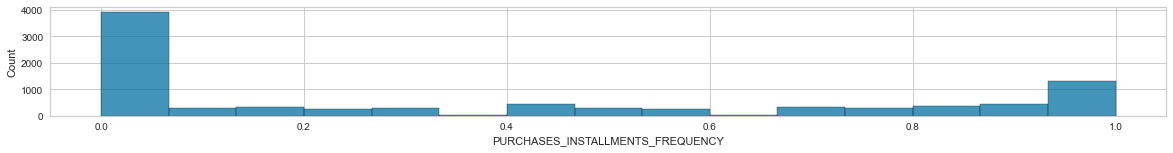

In [22]:
plot1('PURCHASES_INSTALLMENTS_FREQUENCY')

In [23]:
skala('PURCHASES_INSTALLMENTS_FREQUENCY', 'melakukan transaksi dengan metode cicilan')

53.81 % user jarang (0.0 - 0.2) melakukan transaksi dengan metode cicilan
20.18 % user sering (0.9 - 1.0) melakukan transaksi dengan metode cicilan
6.98 % user seringkali (0.5 - 0.6) melakukan transaksi dengan metode cicilan
11.04 % user biasanya (0.7 - 0.8) melakukan transaksi dengan metode cicilan
7.99 % user terkadang (0.3 - 0.4) melakukan transaksi dengan metode cicilan


- `pada kolom PURCHASES_INSTALLMENTS_FREQUENCY, distribusi datanya adalah skewed`

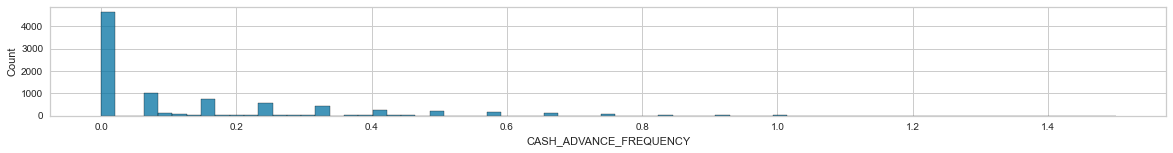

In [24]:
plot1('CASH_ADVANCE_FREQUENCY')

In [25]:
skala('CASH_ADVANCE_FREQUENCY', 'melakukan transaksi dengan pembayaran dimuka (DP)')

81.58 % user jarang (0.0 - 0.2) melakukan transaksi dengan pembayaran dimuka (DP)
9.89 % user terkadang (0.3 - 0.4) melakukan transaksi dengan pembayaran dimuka (DP)
4.77 % user seringkali (0.5 - 0.6) melakukan transaksi dengan pembayaran dimuka (DP)
2.91 % user biasanya (0.7 - 0.8) melakukan transaksi dengan pembayaran dimuka (DP)
0.77 % user sering (0.9 - 1.0) melakukan transaksi dengan pembayaran dimuka (DP)


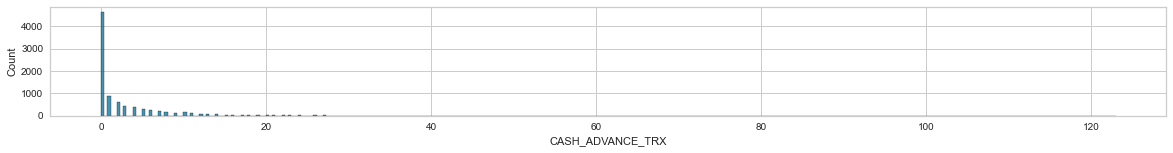

In [26]:
plot1('CASH_ADVANCE_TRX')

In [27]:
jum_dp = round((df[(df['CASH_ADVANCE_TRX'] == 0)].shape[0]/df.shape[0])*100,2)
print(jum_dp,'% user tidak pernah melakukan pembayaran dengan uang muka (DP)')
print(100-jum_dp,'% user pernah melakukan pembayaran dengan uang muka (DP)')

51.71 % user tidak pernah melakukan pembayaran dengan uang muka (DP)
48.29 % user pernah melakukan pembayaran dengan uang muka (DP)


- `pada kolom CASH_ADVANCE_TRX, distribusi datanya adalah skewed`

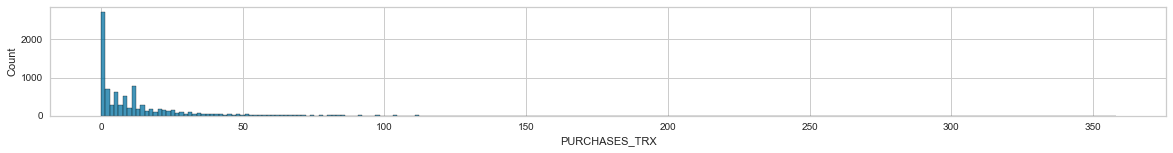

In [28]:
plot1('PURCHASES_TRX')

In [29]:
jum_trk = round((df[(df['PURCHASES_TRX'] == 0)].shape[0]/df.shape[0])*100,2)
print(jum_trk,'% user tidak pernah melakukan tranksaksi selama 6 bulan terakhir dengan kartu kredit')
print(100-jum_trk,'% user setidaknya pernah melakukan satu transaksi selama 6 bulan terakhir dengan kartu kredit')

22.84 % user tidak pernah melakukan tranksaksi selama 6 bulan terakhir dengan kartu kredit
77.16 % user setidaknya pernah melakukan satu transaksi selama 6 bulan terakhir dengan kartu kredit


- `pada kolom PURCHASES_TRX, distribusi datanya adalah skewed`

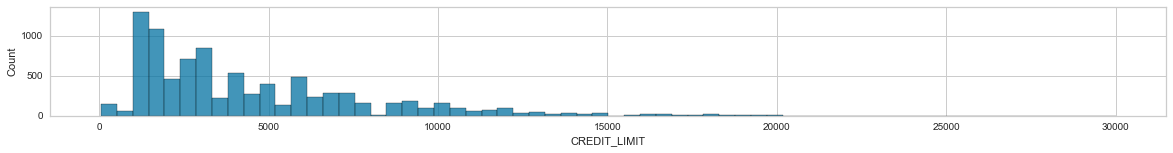

In [30]:
plot1('CREDIT_LIMIT')

In [31]:
summ_limit = df['CREDIT_LIMIT'].value_counts().reset_index().rename(columns={'index':'credit_limit', 'CREDIT_LIMIT':'number_of_credit_limit'})

In [32]:
print('limit minimum kartu kredit yang dimiliki user adalah',df['CREDIT_LIMIT'].min(),'dollar')
print('limit maksimum kartu kredit yang dimiliki user adalah',df['CREDIT_LIMIT'].max(),'dollar')
print('limit rata-rata kartu kredit yang dimiliki user adalah',round(df['CREDIT_LIMIT'].mean(),2),'dollar')
print('limit kartu kredit terbanyak yang dimiliki user adalah',summ_limit.loc[0][0],'dollar, dengan total user sebanyak',summ_limit.loc[0][1],'orang')

limit minimum kartu kredit yang dimiliki user adalah 50.0 dollar
limit maksimum kartu kredit yang dimiliki user adalah 30000.0 dollar
limit rata-rata kartu kredit yang dimiliki user adalah 4494.45 dollar
limit kartu kredit terbanyak yang dimiliki user adalah 3000.0 dollar, dengan total user sebanyak 784.0 orang


- `pada kolom CREDIT_LIMIT, distribusi datanya adalah skewed`

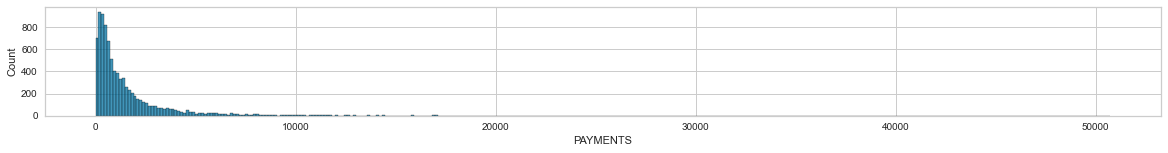

In [33]:
plot1('PAYMENTS')

In [34]:
tag_cc = round((df[df['PAYMENTS'] == 0].shape[0]/df.shape[0])*100,2)
print(tag_cc, '% user tidak memiliki tagihan pembayaran kartu kredit')
print(100 - tag_cc, '% user memiliki tagihan pembayaran kartu kredit')
print('\ntagihan pembayaran tertinggi adalah',round(df['PAYMENTS'].max(),2),'dollar')
print('rata-rata tagihan pembayaran adalah',round(df['PAYMENTS'].mean(),2),'dollar')

2.68 % user tidak memiliki tagihan pembayaran kartu kredit
97.32 % user memiliki tagihan pembayaran kartu kredit

tagihan pembayaran tertinggi adalah 50721.48 dollar
rata-rata tagihan pembayaran adalah 1733.14 dollar


- `pada kolom PAYMENTS, distribusi datanya adalah skewed`

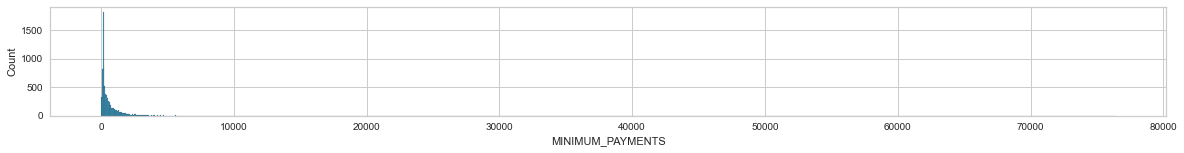

In [35]:
plot1('MINIMUM_PAYMENTS')

In [36]:
min_pay = round((df['MINIMUM_PAYMENTS'].isna().sum()/df.shape[0])*100,2)
print(min_pay, '% user tidak memiliki minimum tagihan pembayaran kartu kredit')
print(100 - min_pay, '% user memiliki minimum tagihan pembayaran kartu kredit')
print('\nminimum tagihan pembayaran tertinggi adalah',round(df['MINIMUM_PAYMENTS'].max(),2),'dollar')
print('rata-rata minimum tagihan pembayaran adalah',round(df['MINIMUM_PAYMENTS'].mean(),2),'dollar')

3.5 % user tidak memiliki minimum tagihan pembayaran kartu kredit
96.5 % user memiliki minimum tagihan pembayaran kartu kredit

minimum tagihan pembayaran tertinggi adalah 76406.21 dollar
rata-rata minimum tagihan pembayaran adalah 864.21 dollar


- `pada kolom MINIMUM_PAYMENTS, distribusi datanya adalah skewed`

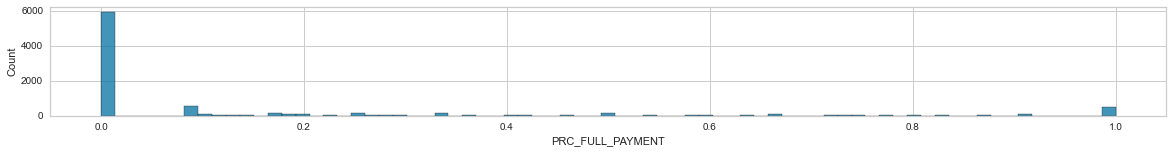

In [37]:
plot1('PRC_FULL_PAYMENT')

In [38]:
skala1('PRC_FULL_PAYMENT')

65.96 %  user belum melakukan pembayaran tagihan sama sekali
14.97 %  user melakukan pembayaran tagihan sebesar 10% - 20%  dari total tagihan
5.05 %  user melakukan pembayaran tagihan sebesar 30% - 40%  dari total tagihan
4.68 %  user melakukan pembayaran tagihan sebesar 50% - 60%  dari total tagihan
3.18 %  user melakukan pembayaran tagihan sebesar 90% - 100%  dari total tagihan
2.8 %  user melakukan pembayaran tagihan sebesar 70% - 80%  dari total tagihan


- `pada kolom PRC_FULL_PAYMENT, distribusi datanya adalah skewed`

In [39]:
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

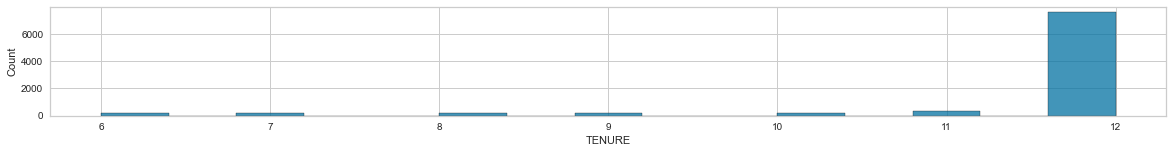

In [40]:
plot1('TENURE')

In [41]:
for i in df['TENURE'].sort_values().unique():
    # print(i)
    if i == 6:
        print('persentase user dengan tenor',i,'bulan ada sebanyak',round((df['TENURE'].value_counts()[i]/df['TENURE'].shape[0])*100,2),'%')
    
    if i == 7:
        print('persentase user dengan tenor',i,'bulan ada sebanyak',round((df['TENURE'].value_counts()[i]/df['TENURE'].shape[0])*100,2),'%')
    
    if i == 8:
        print('persentase user dengan tenor',i,'bulan ada sebanyak',round((df['TENURE'].value_counts()[i]/df['TENURE'].shape[0])*100,2),'%')
    
    if i == 9:
        print('persentase user dengan tenor',i,'bulan ada sebanyak',round((df['TENURE'].value_counts()[i]/df['TENURE'].shape[0])*100,2),'%')
    
    if i == 10:
        print('persentase user dengan tenor',i,'bulan ada sebanyak',round((df['TENURE'].value_counts()[i]/df['TENURE'].shape[0])*100,2),'%')
    
    if i == 11:
        print('persentase user dengan tenor',i,'bulan ada sebanyak',round((df['TENURE'].value_counts()[i]/df['TENURE'].shape[0])*100,2),'%')
    
    if i == 12:
        print('persentase user dengan tenor',i,'bulan ada sebanyak',round((df['TENURE'].value_counts()[i]/df['TENURE'].shape[0])*100,2),'%')


persentase user dengan tenor 6 bulan ada sebanyak 2.28 %
persentase user dengan tenor 7 bulan ada sebanyak 2.12 %
persentase user dengan tenor 8 bulan ada sebanyak 2.19 %
persentase user dengan tenor 9 bulan ada sebanyak 1.96 %
persentase user dengan tenor 10 bulan ada sebanyak 2.64 %
persentase user dengan tenor 11 bulan ada sebanyak 4.08 %
persentase user dengan tenor 12 bulan ada sebanyak 84.74 %


- `pada kolom TENURE, distribusi datanya adalah skewed`

## 3.b. Cek Korelasi

<AxesSubplot:>

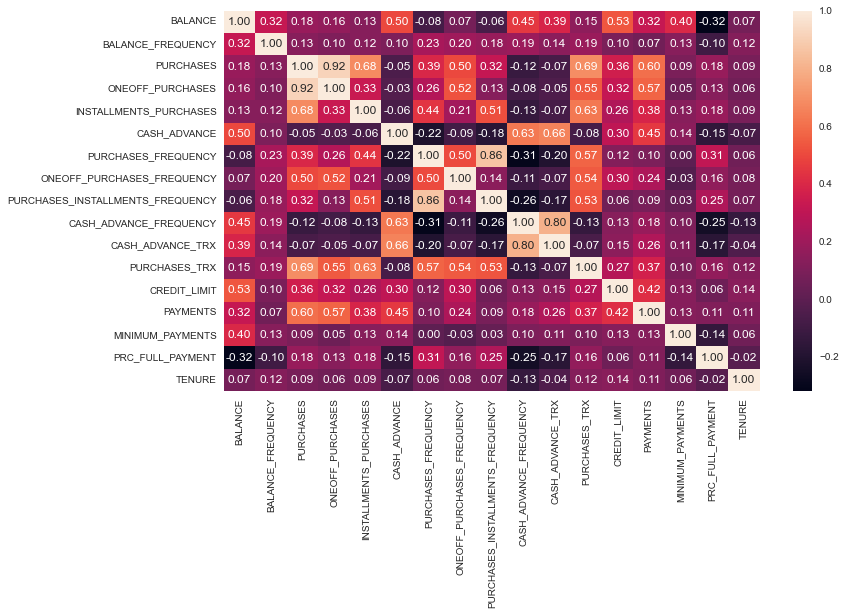

In [42]:
korelasi = df.corr()
plt.figure(figsize=(12,7))

sns.heatmap(korelasi, annot=True, fmt='.2f')

- `Purchases dan oneoff_purchases memiliki korelasi berbanding lurus yang tinggi`
- `Purchases_frequency dan purchases_installment_frequency memiliki korelasi berbanding lurus yang tinggi`
- `cash advance transaction dan cash advance frequency memiliki korelasi berbanding lurus yang tinggi`
- `Balance dan PRC full payment memiliki korelasi berbanding terbalikk yang tinggi`
- `cash advance frequency dan purchases frequency memiliki korelasi berbanding terbalik yang tinggi`

- `dari tabel korelasi, terlihat bahwa fitur TENURE tidak memiliki nilai korelasi dengan fitur lain diatas 0.2 dan dibawah -0.2`

## 3.c Cek Ouliers

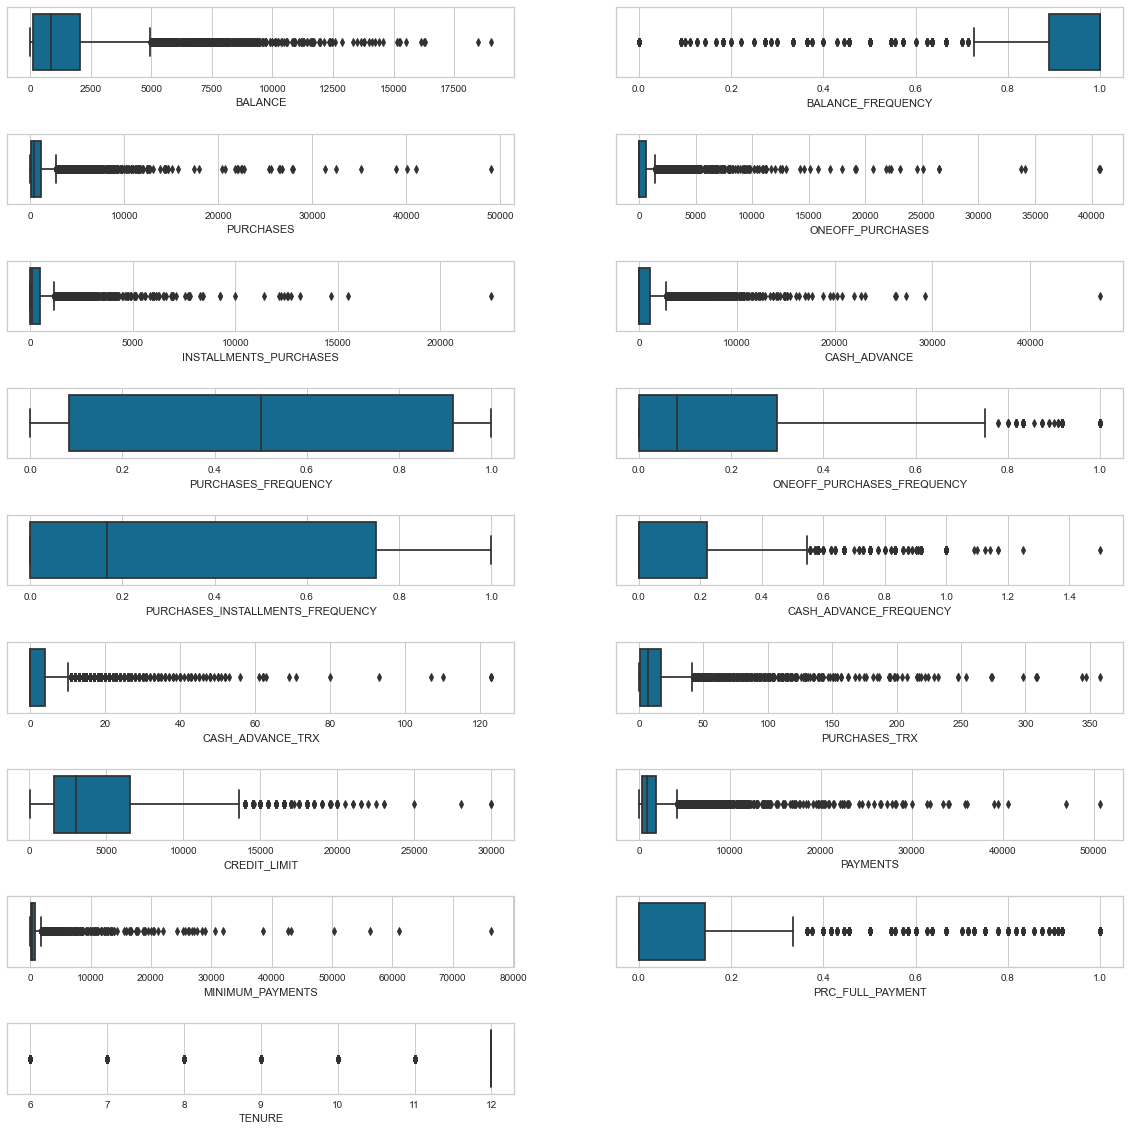

In [43]:
fig = plt.figure()
fig.set_size_inches(20, 20)
fig.subplots_adjust(hspace=0.8, wspace=0.2)

jum = 1
for i in range(len(df.columns)):
    ax = fig.add_subplot(9, 2, jum)
    sns.boxplot(x= df.columns[i], data=df)
    # plt.title(X_train[numerik].columns[i])
    jum+= 1

`terlihat ada banyak outlier pada hampir semua fitur yang ada, namun sebelum menangani outlier tersebut ada baiknya mengecek missing value terlebih dahulu` 

# 4. <i>Preprocessing</i>

## 4.a Cek Statistik Dasar

In [44]:
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## 4.b <i>Handle Missing Value</i>

In [45]:
df.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

`terdapat 313 missing value pada kolom MINIMUM_PAYMENTS dan 1 missing value pada colom CREDIT_LIMIT`

`NaN pada MINIMUM_PAYMENTS akan dianggap / diganti dengan median dari MINIMUM_PAYMENTS`

In [46]:
df['MINIMUM_PAYMENTS'] = df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median())

`NaN pada CREDIT_LIMIT akan dianggap / diganti dengan median dari CREDIT_LIMIT`

In [47]:
df['CREDIT_LIMIT'] = df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].median())

## 4.c <i>Handle Outliers</i>

In [52]:
def cek_iqr(df, col):
    q1 = df[col].quantile(0.25) # 25% percentile
    q3 = df[col].quantile(0.75) # 75% percentile
    
    IQR = q3-q1
    bawah  = q1-1.5*IQR
    atas = q3+1.5*IQR
    
    return IQR, bawah, atas


# fungsi untuk mengecek data outlier

def cek_outlier(df, col):   
    iqr, bawah, atas = cek_iqr(df,col)
    return df[(df[col] < bawah) | (df[col] > atas)]

In [53]:
for i in df:
    print('fitur',i,' : outlier', cek_outlier(df, i)[i].size)

fitur BALANCE  : outlier 695
fitur BALANCE_FREQUENCY  : outlier 1493
fitur PURCHASES  : outlier 808
fitur ONEOFF_PURCHASES  : outlier 1013
fitur INSTALLMENTS_PURCHASES  : outlier 867
fitur CASH_ADVANCE  : outlier 1030
fitur PURCHASES_FREQUENCY  : outlier 0
fitur ONEOFF_PURCHASES_FREQUENCY  : outlier 782
fitur PURCHASES_INSTALLMENTS_FREQUENCY  : outlier 0
fitur CASH_ADVANCE_FREQUENCY  : outlier 525
fitur CASH_ADVANCE_TRX  : outlier 804
fitur PURCHASES_TRX  : outlier 766
fitur CREDIT_LIMIT  : outlier 248
fitur PAYMENTS  : outlier 808
fitur MINIMUM_PAYMENTS  : outlier 909
fitur PRC_FULL_PAYMENT  : outlier 1474
fitur TENURE  : outlier 1366


`terlihat bahwa ada banyak outlier`

`outlier akan di`<i>`handling`</i>` menggunakan metode Winsorizer`

In [54]:
df.shape

(8950, 17)

In [477]:
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [478]:
windsoriser = Winsorizer(capping_method='iqr', tail='both',
                          fold=1.5,
                          variables=['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
                                     'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY','CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
                                     'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT','TENURE'])

## 4.d <i>Data Normalization</i>

`Data akan dinormalisasi agar semua fitur memiliki skala yang sama dengan menggunakan metode MinMaxScaler`

In [479]:
scaler = MinMaxScaler()

pipe = Pipeline([('windsoriser', windsoriser), ('scaler', scaler)])

In [480]:
new_df = pd.DataFrame(pipe.fit(df), columns=df.columns)

In [481]:
# pipe.fit(df)
# new_df = pipe.transform(df)

# 5. <i>Modelling</i>

## 5.1 K-MEANS

### 5.1.a Find an Optimum K

##### Mendefinisikan Baseline

In [482]:
kmeans = KMeans(random_state=200)

In [483]:
kmeans.fit(new_df)

KMeans(random_state=200)

##### K Elbow Visualizer (yellowbrick library)

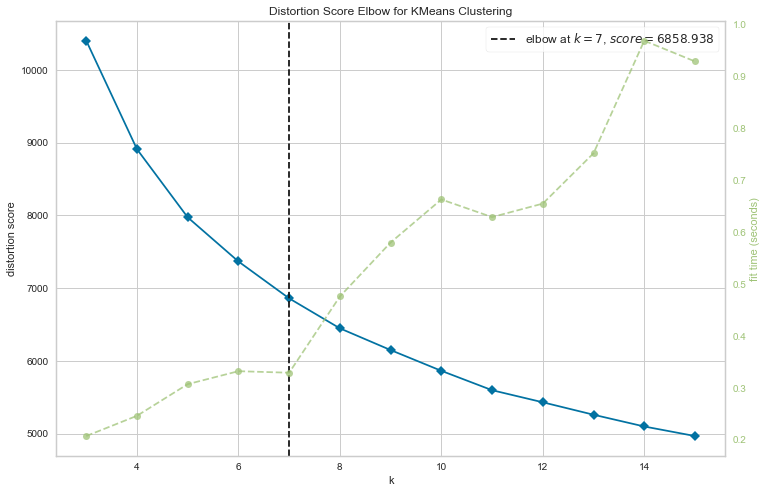

In [484]:
kelbow_method = kelbow_visualizer(kmeans, new_df, k=(3,16), figsize=(8,8))

`berdasarkan dari k-elbow method yang telah digunakan untuk mencari optimum k, didapatkan bahwa optimum k adalah 7`

### 5.1.b Training Model

In [509]:
kmeans_opt= KMeans(n_clusters=7, init = 'k-means++', max_iter = 300, n_init= 10, random_state=200)

In [545]:
pipe2 = Pipeline([('pipe', pipe), ('kmeans', kmeans_opt)])

In [546]:
pipe2.fit_predict(df)

array([5, 0, 6, ..., 4, 5, 6])

In [511]:
df_vis = data.copy()

# menghapus fitur CUST_ID
df_vis = df_vis.drop('CUST_ID', axis = 1)

# fitur CLUSTER adalah hasil clustering
df_vis['CLUSTER'] = pipe2.fit_predict(df)

# fitur constant ini akan digunakan untuk visualisasi
df_vis['constant'] = 'constant'

### 5.1.c Conclusion

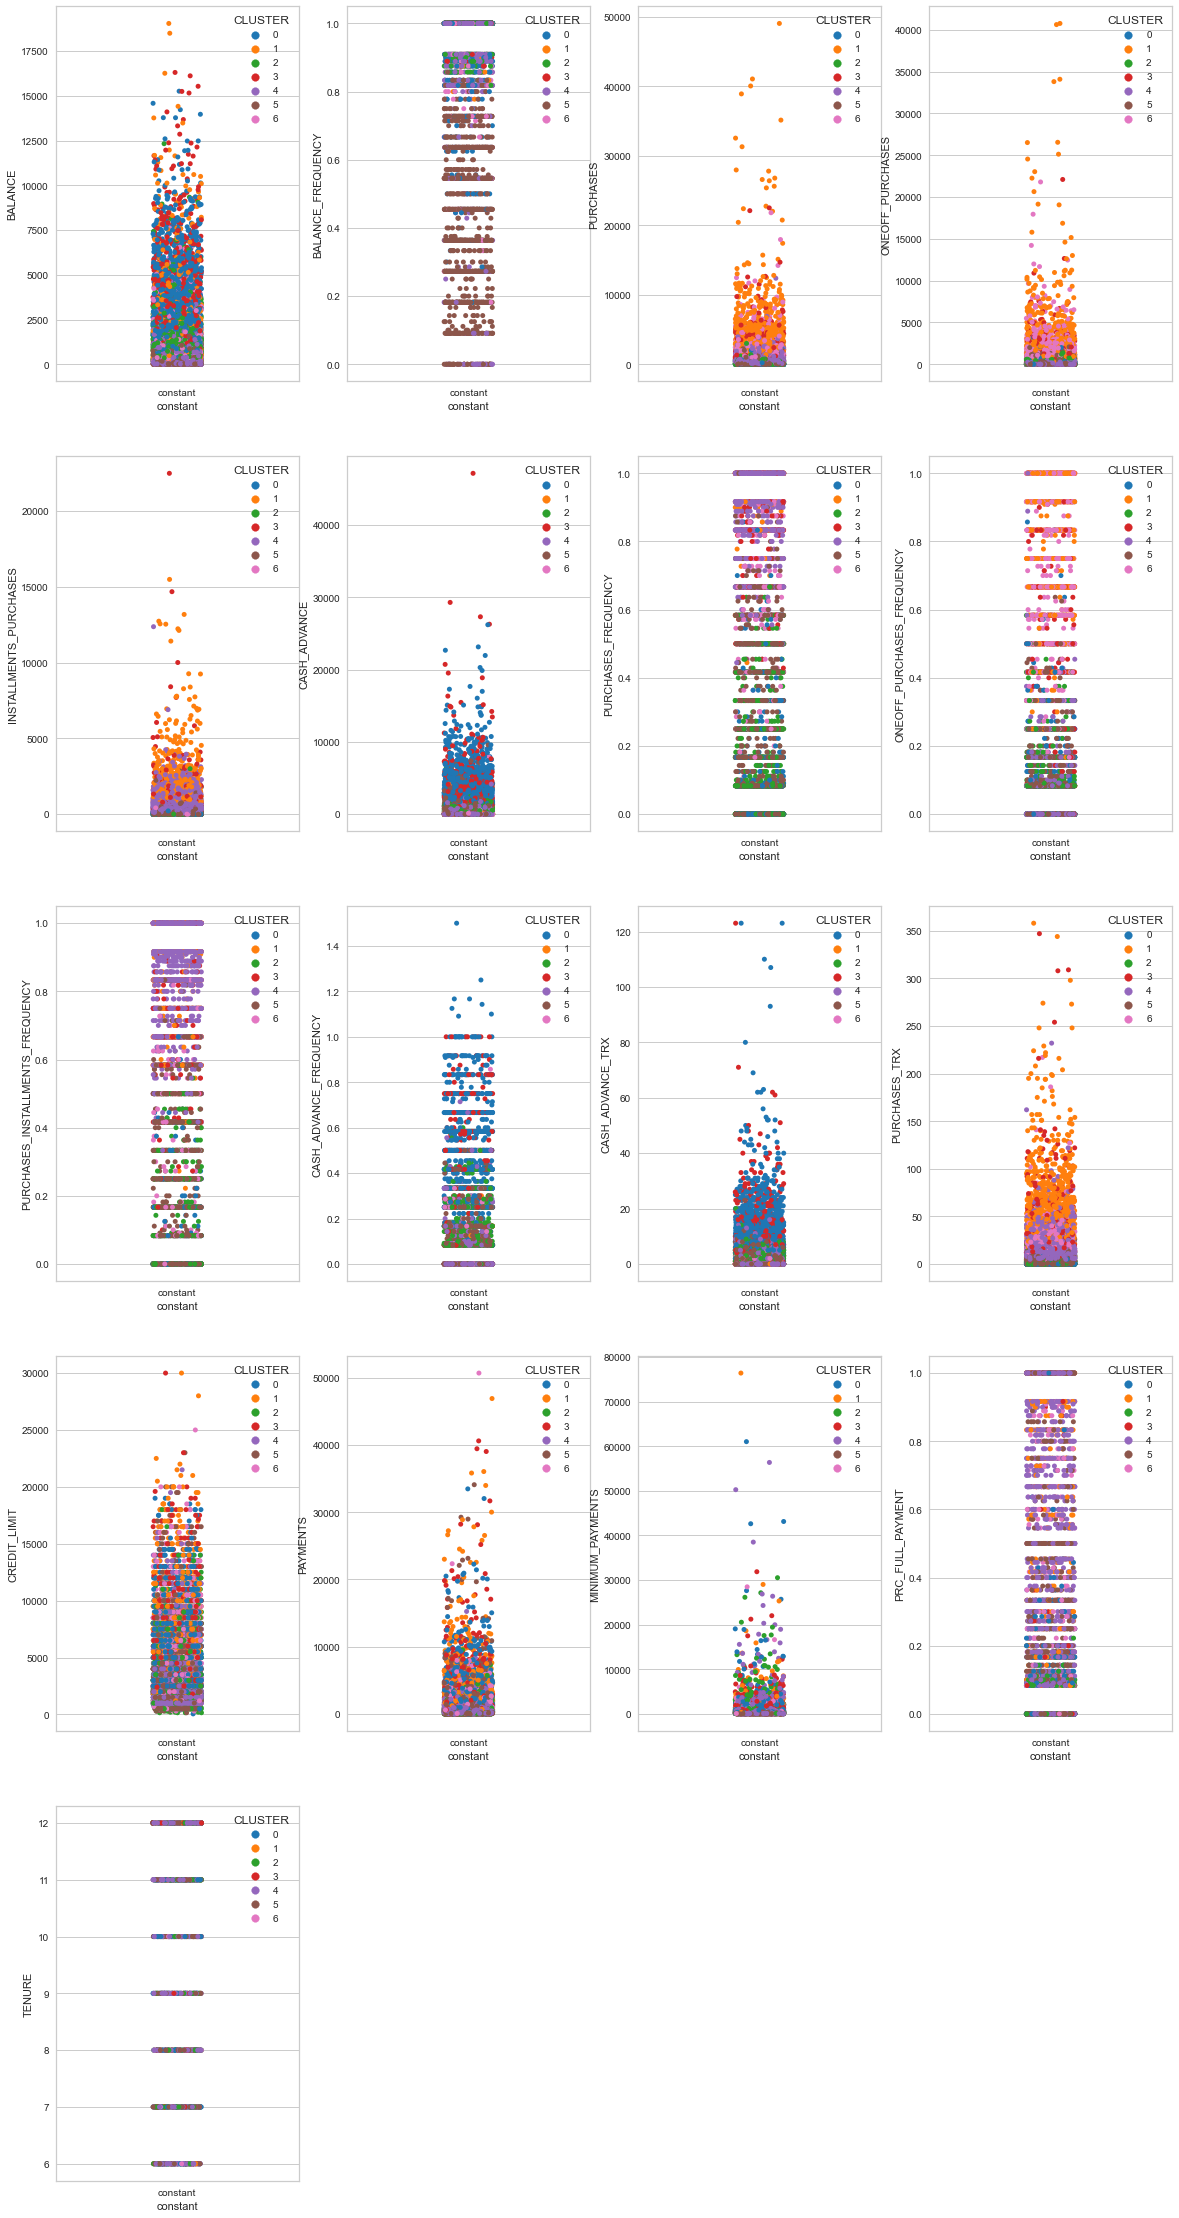

In [512]:
plt.rcParams['figure.figsize'] =(20,40)

for num in range(0,17):
    ax = plt.subplot(5,4,num+1)
    col = df_vis.columns[num]
    sns.stripplot(df_vis['constant'],df_vis[col], ax=ax, hue=df_vis['CLUSTER'], palette = 'tab10')
    plt.xlabel('constant')

- `Cluster 0 mempunyai balance yang menengah keatas tidak terlalu sering belanja dan belaja barang mahal tetapi senang belanja dengan membayar uang muka`

- `Cluster 1 adalah cluster dengan rata-rata balance terbesar dan juga boros karena sering belanja barang yang mahal, dan tidak terlalu senang membayar dengan uang muka, sering melakukan isi ulang dan lumayan sering melakukan pembayaran dengan full payment`

- `Cluster 2 mempunyai balance yang menengah keatas tidak terlalu sering belanja dan belaja barang mahal`

- `Cluster 3 mempunyai balance yang banyak serta sering belanja dan belanja barang mewah dan juga senang membayar dengan uang muka`

- `Cluster 4 mempunyai balance yang terbilang paling kecil atau 0, usernya terbilang bervariasi karena ada yang sering mengisi saldo dan ada yang jarang namun sering habis karena sering belanja dan belanja barang mewah namun sering membayar dengan full payment`

- `Cluster 5 mempunyai balance yang terbilang paling kecil atau 0, terbilang jarang isi ulang, jarang belanja dan belanja barang mewah, jarang melakukan pembayaran dengan full payment`

- `Cluster 6 mempunyai balance menengah keatas, lumayan sering untuk isi ulang saldo akan tetapi sering belanja dan belanja barang mewah serta sering melakukan pembayaran dengan full payment`

Text(0, 0.5, 'Purchases')

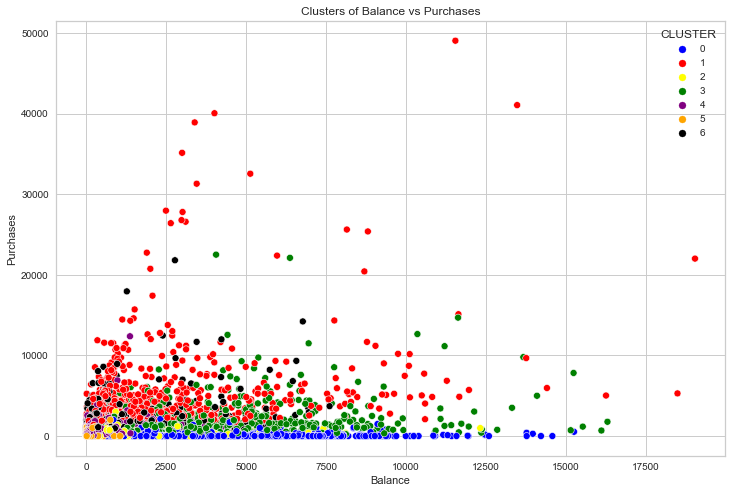

In [513]:
# A closer look at balance vs purchases with clusters centers
plt.rcParams['figure.figsize'] = (12,8)
sns.scatterplot(df_vis['BALANCE'],df_vis['PURCHASES'], hue=df_vis['CLUSTER'], palette=['blue','red','yellow','green', 'purple', 'orange', 'black'])
plt.title('Clusters of Balance vs Purchases')
plt.xlabel('Balance')
plt.ylabel('Purchases')

`Secara garis besar, cluster 1 adalah cluster yang paling berpotensi untuk didekati kemudian disusul oleh cluster 3,6,4,0,2,5`

## 5.2 Gaussian Mixture

### 5.2.a Find an Cluster

#### Mencari nilai BIC & AIC

In [369]:
gas = [GaussianMixture(n_components=k, n_init=10, random_state=200).fit(new_df)
        for k in range(1, 16)]

In [370]:
# bic = [model.bic(new_df) for model in gas]
# aic = [model.aic(new_df) for model in gas]

In [371]:
# plt.figure(figsize=(10,10))
# plt.plot(range(1, 16), bic, label="BIC")
# plt.plot(range(1, 16), aic, label="AIC")
# plt.title('K Optimum for Gaussian Mixture',fontsize=20)
# plt.xlabel("k", fontsize=14)
# plt.ylabel("Information Criterion", fontsize=14)
# plt.axis([1, 9.5, np.min(aic) - 50, np.max(aic) + 50])
# plt.legend()
# plt.show()

`berdasarkan grafik BIC dan AIC, jumlah cluster yang optimal adalah 4, penilaian ini berdasarkan siku yang terbuka lebih lebar daripada yang lainnya`

### Training Model

In [372]:
gas_opt = GaussianMixture(n_components=4, n_init=10, random_state=200)
gas_opt.fit(new_df)

GaussianMixture(n_components=4, n_init=10, random_state=200)

In [373]:
gas_pred = gas_opt.predict(new_df)
gas_pred

array([0, 1, 2, ..., 0, 1, 3], dtype=int64)

In [374]:
# membuat df copy untuk visualisasi 
df_gas = data.copy()

# menghapus fitur CUST_ID
df_gas = df_gas.drop('CUST_ID', axis = 1)

# fitur CLUSTER adalah hasil clustering
df_gas['CLUSTER'] = gas_pred

# fitur constant ini akan digunakan untuk visualisasi
df_gas['constant'] = 'constant'

### 5.2.c Conclusion

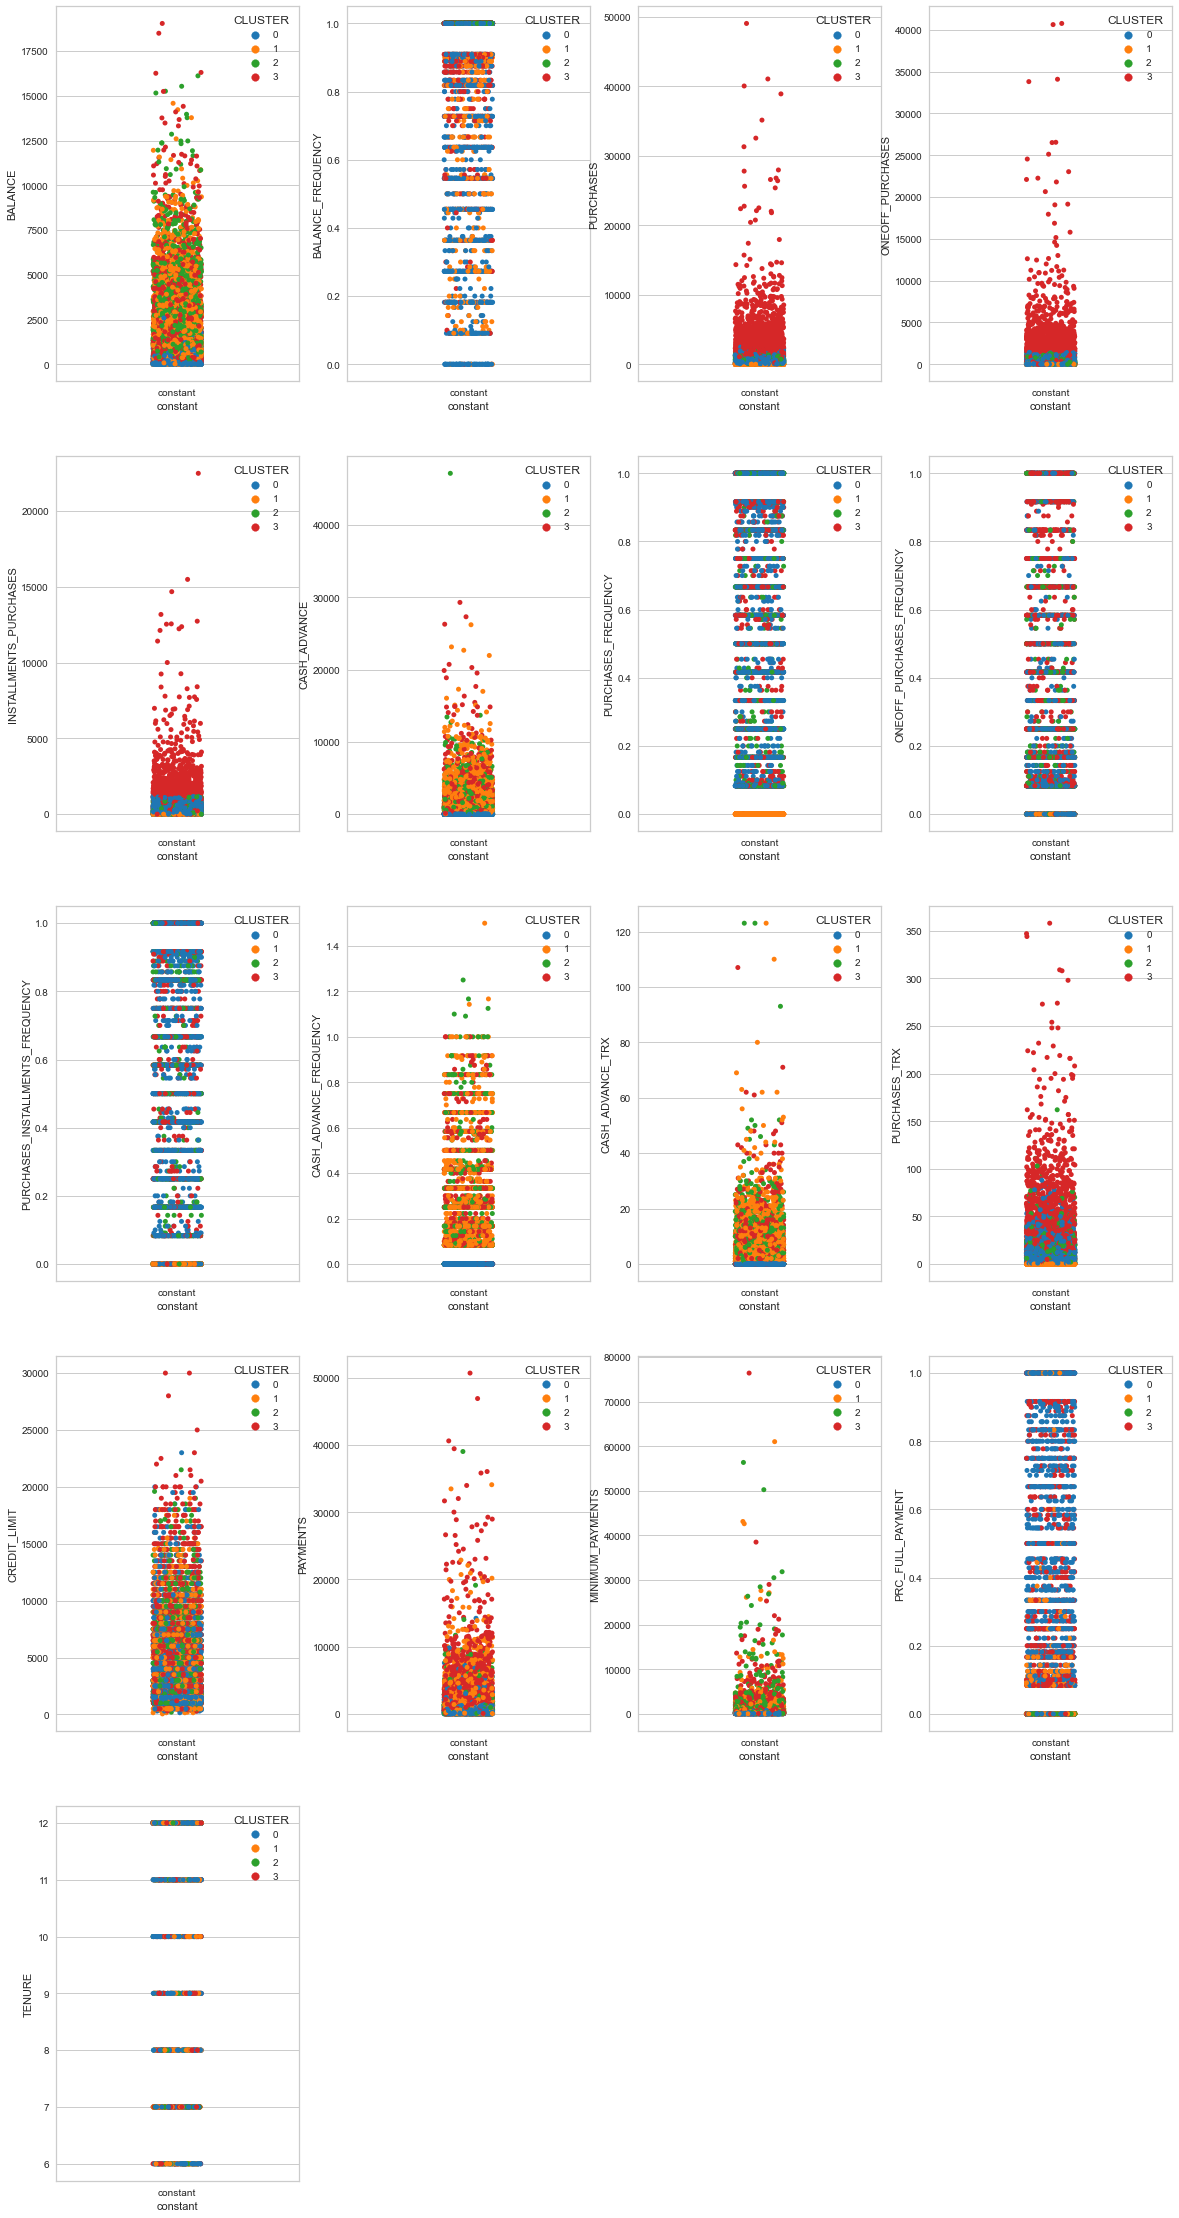

In [375]:
plt.rcParams['figure.figsize'] =(20,40)

for num in range(0,17):
    ax = plt.subplot(5,4,num+1)
    col = df_gas.columns[num]
    sns.stripplot(df_gas['constant'],df_gas[col], ax=ax, hue=df_gas['CLUSTER'], palette = 'tab10')
    plt.xlabel('constant')

- `Cluster 0 mempunyai balance yang rendah tidak terlalu sering belanja dan belaja barang mahal serta tidak suka belanja dengan membayar uang muka`

- `Cluster 1 adalah cluster yang jarang belanja dan tidak belanja barang mahal tetapi memiliki balance menengah keatas, cluster ini lebih suka membayar dengan uang muka`

- `Cluster 2 adalah cluster yang jarang belanja dan tidak belanja barang mahal tetapi memiliki balance menengah keatas, cluster ini lebih suka membayar dengan uang muka`

- `Cluster 3 adalah cluster potensial dimana cluster ini senang belanja dan belanja barang mahal serta mempunyai balance yang banyak dan suka mengisi ulang saldo`

Text(0, 0.5, 'Purchases')

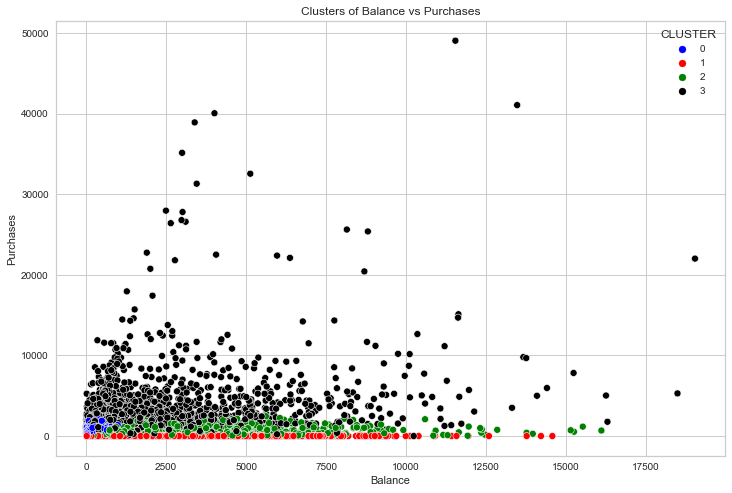

In [376]:
# A closer look at balance vs purchases with clusters centers
plt.rcParams['figure.figsize'] = (12,8)
sns.scatterplot(df_gas['BALANCE'],df_gas['PURCHASES'], hue=df_gas['CLUSTER'], palette=['blue','red','green', 'black'])
plt.title('Clusters of Balance vs Purchases')
plt.xlabel('Balance')
plt.ylabel('Purchases')

`Secara garis besar, cluster 3 adalah cluster yang paling berpotensi untuk didekati kemudian disusul oleh cluster 2,0,1`

## 5.3 Agglomerative Clustering

### 5.3.a Find an Optimum K

#### Mendefinisikan Baseline

In [377]:
agg = AgglomerativeClustering()
agg.fit(new_df)

AgglomerativeClustering()

#### K Elbow Visualizer

In [378]:
kelbow_method_agg = kelbow_visualizer(agg, new_df, k=(3,16), figsize=(8,8))

#### Silhouette Score

In [379]:
for i in range(5,12):
    labels = cluster.AgglomerativeClustering(n_clusters=i).fit(new_df).labels_
    print('silhouette score untuk agglomerative(cluster) = ',str(i),'adalah',str(round(metrics.silhouette_score(new_df, labels, metric='euclidean'),4)))

silhouette score untuk agglomerative(cluster) =  5 adalah 0.1571
silhouette score untuk agglomerative(cluster) =  6 adalah 0.1748
silhouette score untuk agglomerative(cluster) =  7 adalah 0.1813
silhouette score untuk agglomerative(cluster) =  8 adalah 0.1782
silhouette score untuk agglomerative(cluster) =  9 adalah 0.18
silhouette score untuk agglomerative(cluster) =  10 adalah 0.1719
silhouette score untuk agglomerative(cluster) =  11 adalah 0.1629


`berdasarkan silhouette score, nilai k yang paling optimum adalah 7 dengan score 0.1813`

### 5.3.b Training Model

In [380]:
agglomerative = AgglomerativeClustering(n_clusters=7)
agglomerative.fit(new_df)

In [381]:
# membuat df copy untuk visualisasi 
df_agg = data.copy()

# menghapus fitur CUST_ID
df_agg = df_agg.drop('CUST_ID', axis = 1)

# fitur CLUSTER adalah hasil clustering
df_agg['CLUSTER'] = agglomerative.labels_

# fitur constant ini akan digunakan untuk visualisasi
df_agg['constant'] = 'constant'

### 5.3.c Conclusion

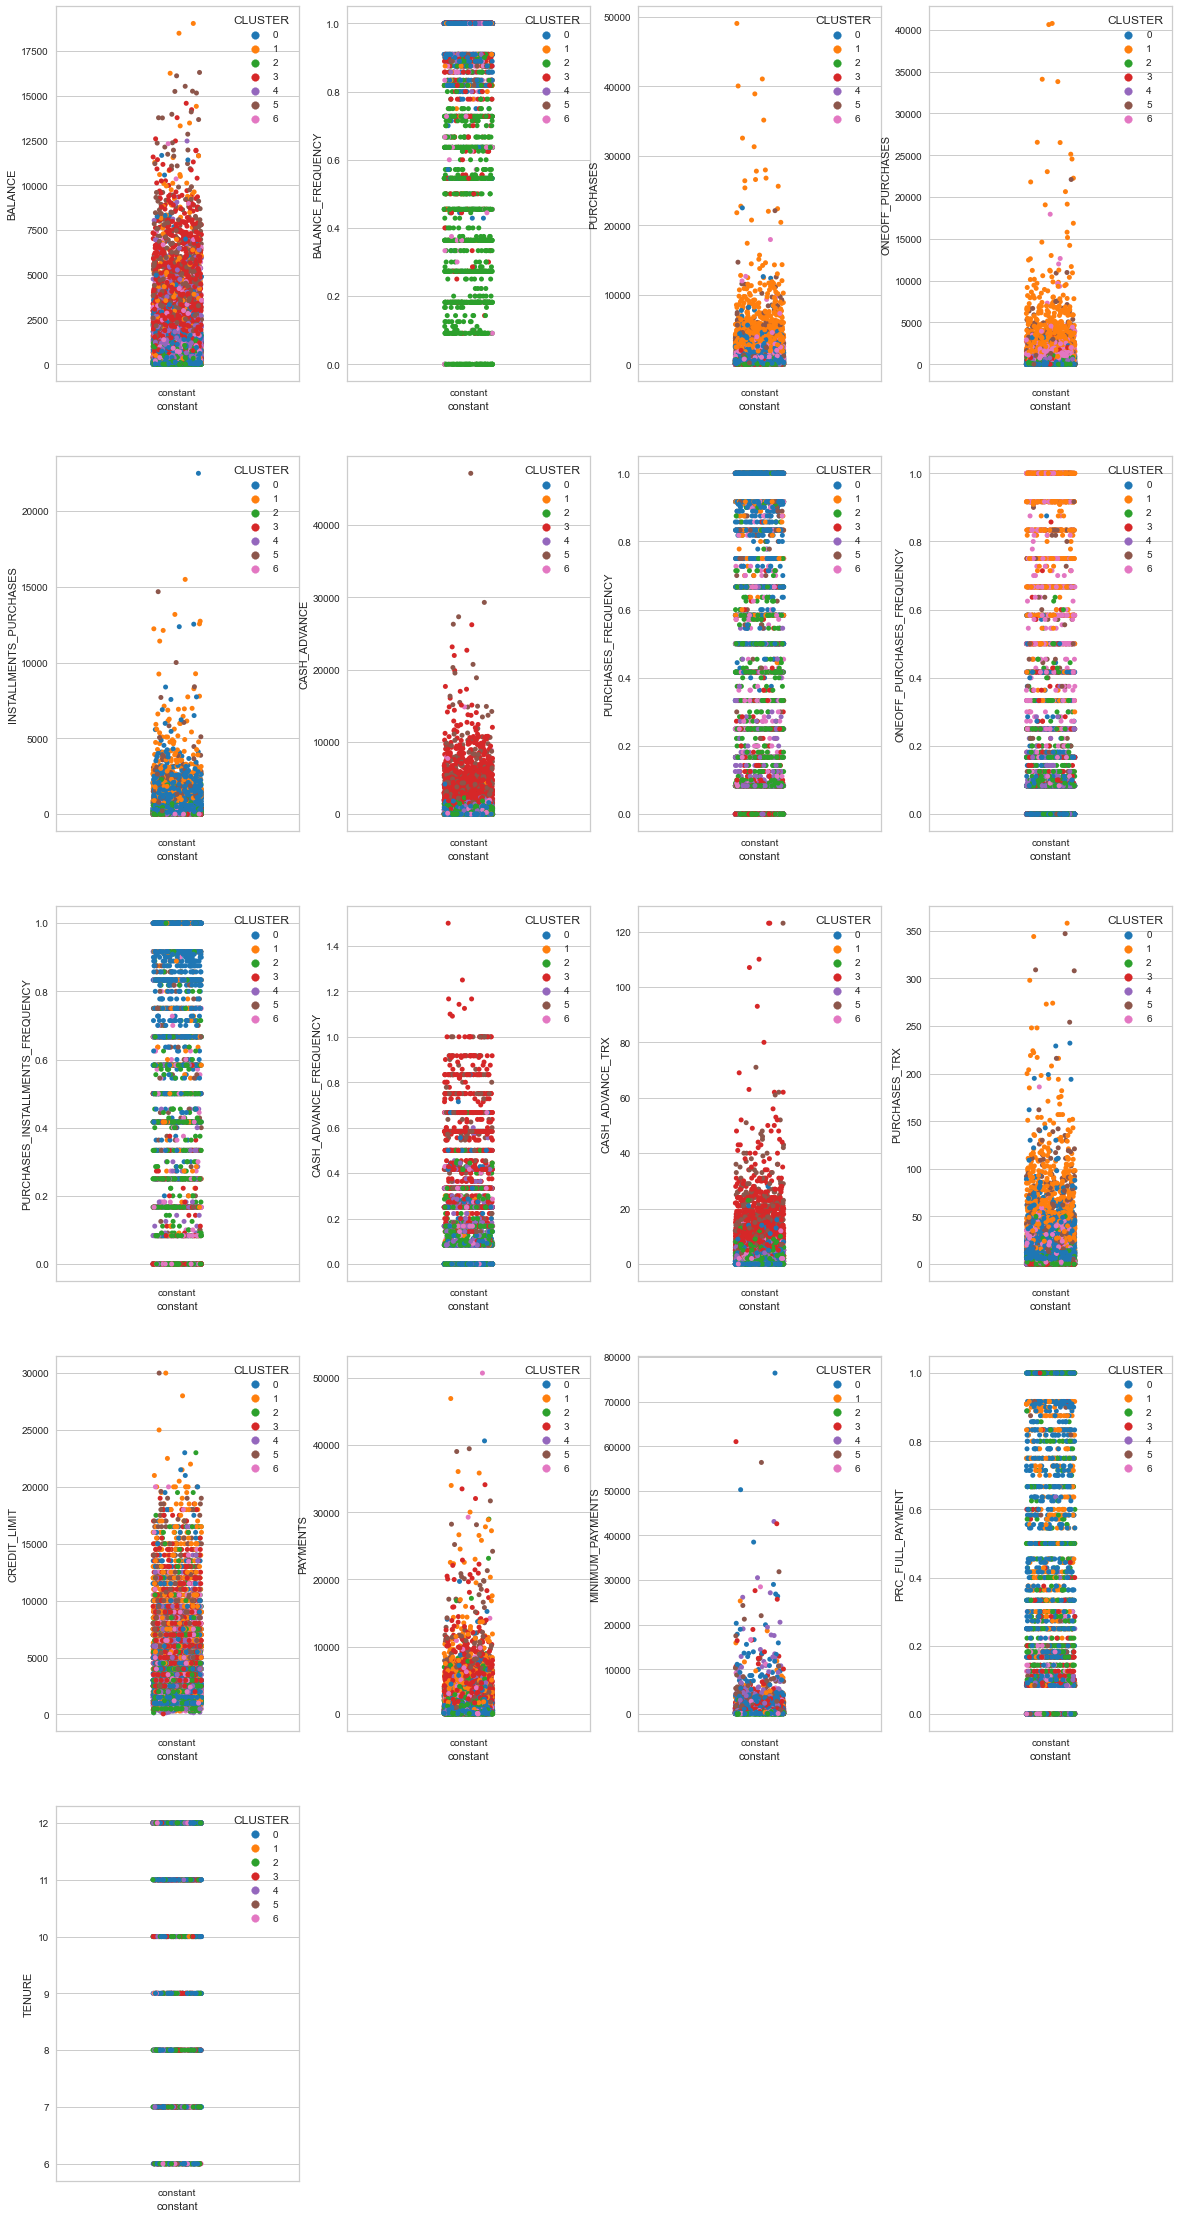

In [382]:
plt.rcParams['figure.figsize'] =(20,40)

for num in range(0,17):
    ax = plt.subplot(5,4,num+1)
    col = df_agg.columns[num]
    sns.stripplot(df_agg['constant'],df_agg[col], ax=ax, hue=df_agg['CLUSTER'], palette = 'tab10')
    plt.xlabel('constant')

- `Cluster 0 mempunyai balance yang menengah keatas tidak terlalu sering belanja dan belaja barang mahal tetapi senang belanja dengan membayar uang muka`

- `Cluster 1 adalah cluster dengan rata-rata balance terbesar dan juga boros karena sering belanja barang yang mahal, dan tidak terlalu senang membayar dengan uang muka, sering melakukan isi ulang dan lumayan sering melakukan pembayaran dengan full payment`

- `Cluster 2 mempunyai balance yang menengah keatas tidak terlalu sering belanja dan belaja barang mahal`

- `Cluster 3 mempunyai balance yang banyak serta sering belanja dan belanja barang mewah dan juga senang membayar dengan uang muka`

- `Cluster 4 mempunyai balance yang terbilang paling kecil atau 0, usernya terbilang bervariasi karena ada yang sering mengisi saldo dan ada yang jarang namun sering habis karena sering belanja dan belanja barang mewah namun sering membayar dengan full payment`

- `Cluster 5 mempunyai balance yang terbilang paling kecil atau 0, terbilang jarang isi ulang, jarang belanja dan belanja barang mewah, jarang melakukan pembayaran dengan full payment`

- `Cluster 6 mempunyai balance menengah keatas, lumayan sering untuk isi ulang saldo akan tetapi sering belanja dan belanja barang mewah serta sering melakukan pembayaran dengan full payment`

Text(0, 0.5, 'Purchases')

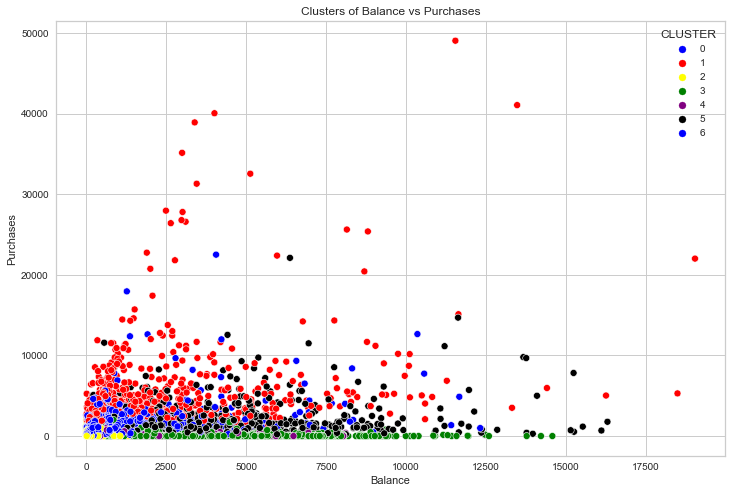

In [383]:
plt.rcParams['figure.figsize'] = (12,8)
sns.scatterplot(df_agg['BALANCE'],df_agg['PURCHASES'], hue=df_agg['CLUSTER'], palette=['blue','red','yellow','green', 'purple', 'black', 'blue'])
plt.title('Clusters of Balance vs Purchases')
plt.xlabel('Balance')
plt.ylabel('Purchases')

`Secara garis besar, cluster 1 adalah cluster yang paling berpotensi untuk didekati kemudian disusul oleh cluster 3,6,4,0,2,5`

## 5.4 DBSCAN

### 5.4.a Find an Optimum Epsilon

#### Mendefinisikan Nearest Neighbours

In [384]:
nearestneighbors = NearestNeighbors (n_neighbors=2)
eps_nn = nearestneighbors.fit(new_df)

In [385]:
distances, indices = eps_nn.kneighbors(new_df)

Text(0, 0.5, 'Epsilon')

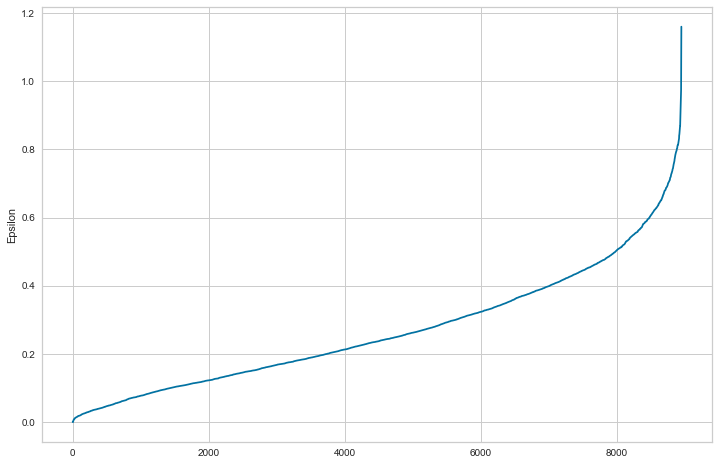

In [386]:
distances = np.sort(distances , axis = 0)
distances = distances [:,1]
plt.plot(distances)
plt.ylabel('Epsilon')

`berdasarkan dari hasil plot distances, titik lekukan berada pada 0.6`

### 5.4.b Training Model

In [387]:
dbscan_opt = DBSCAN(eps=0.6, min_samples=10)
dbscan_opt.fit(new_df)

DBSCAN(eps=0.6, min_samples=10)

In [388]:
# membuat df copy untuk visualisasi 
df_db = data.copy()

# menghapus fitur CUST_ID
df_db = df_db.drop('CUST_ID', axis = 1)

# fitur CLUSTER adalah hasil clustering
df_db['CLUSTER'] = dbscan_opt.labels_

# mengganti nilai -1 pada fitur CLUSTER menjadi 1
df_db['CLUSTER'] = df_db['CLUSTER'].replace([-1],1)

# fitur constant ini akan digunakan untuk visualisasi
df_db['constant'] = 'constant'

# print jumlah data pada cluster
df_db['CLUSTER'].value_counts()

0    8006
1     944
Name: CLUSTER, dtype: int64

### 5.4.c Conclusion

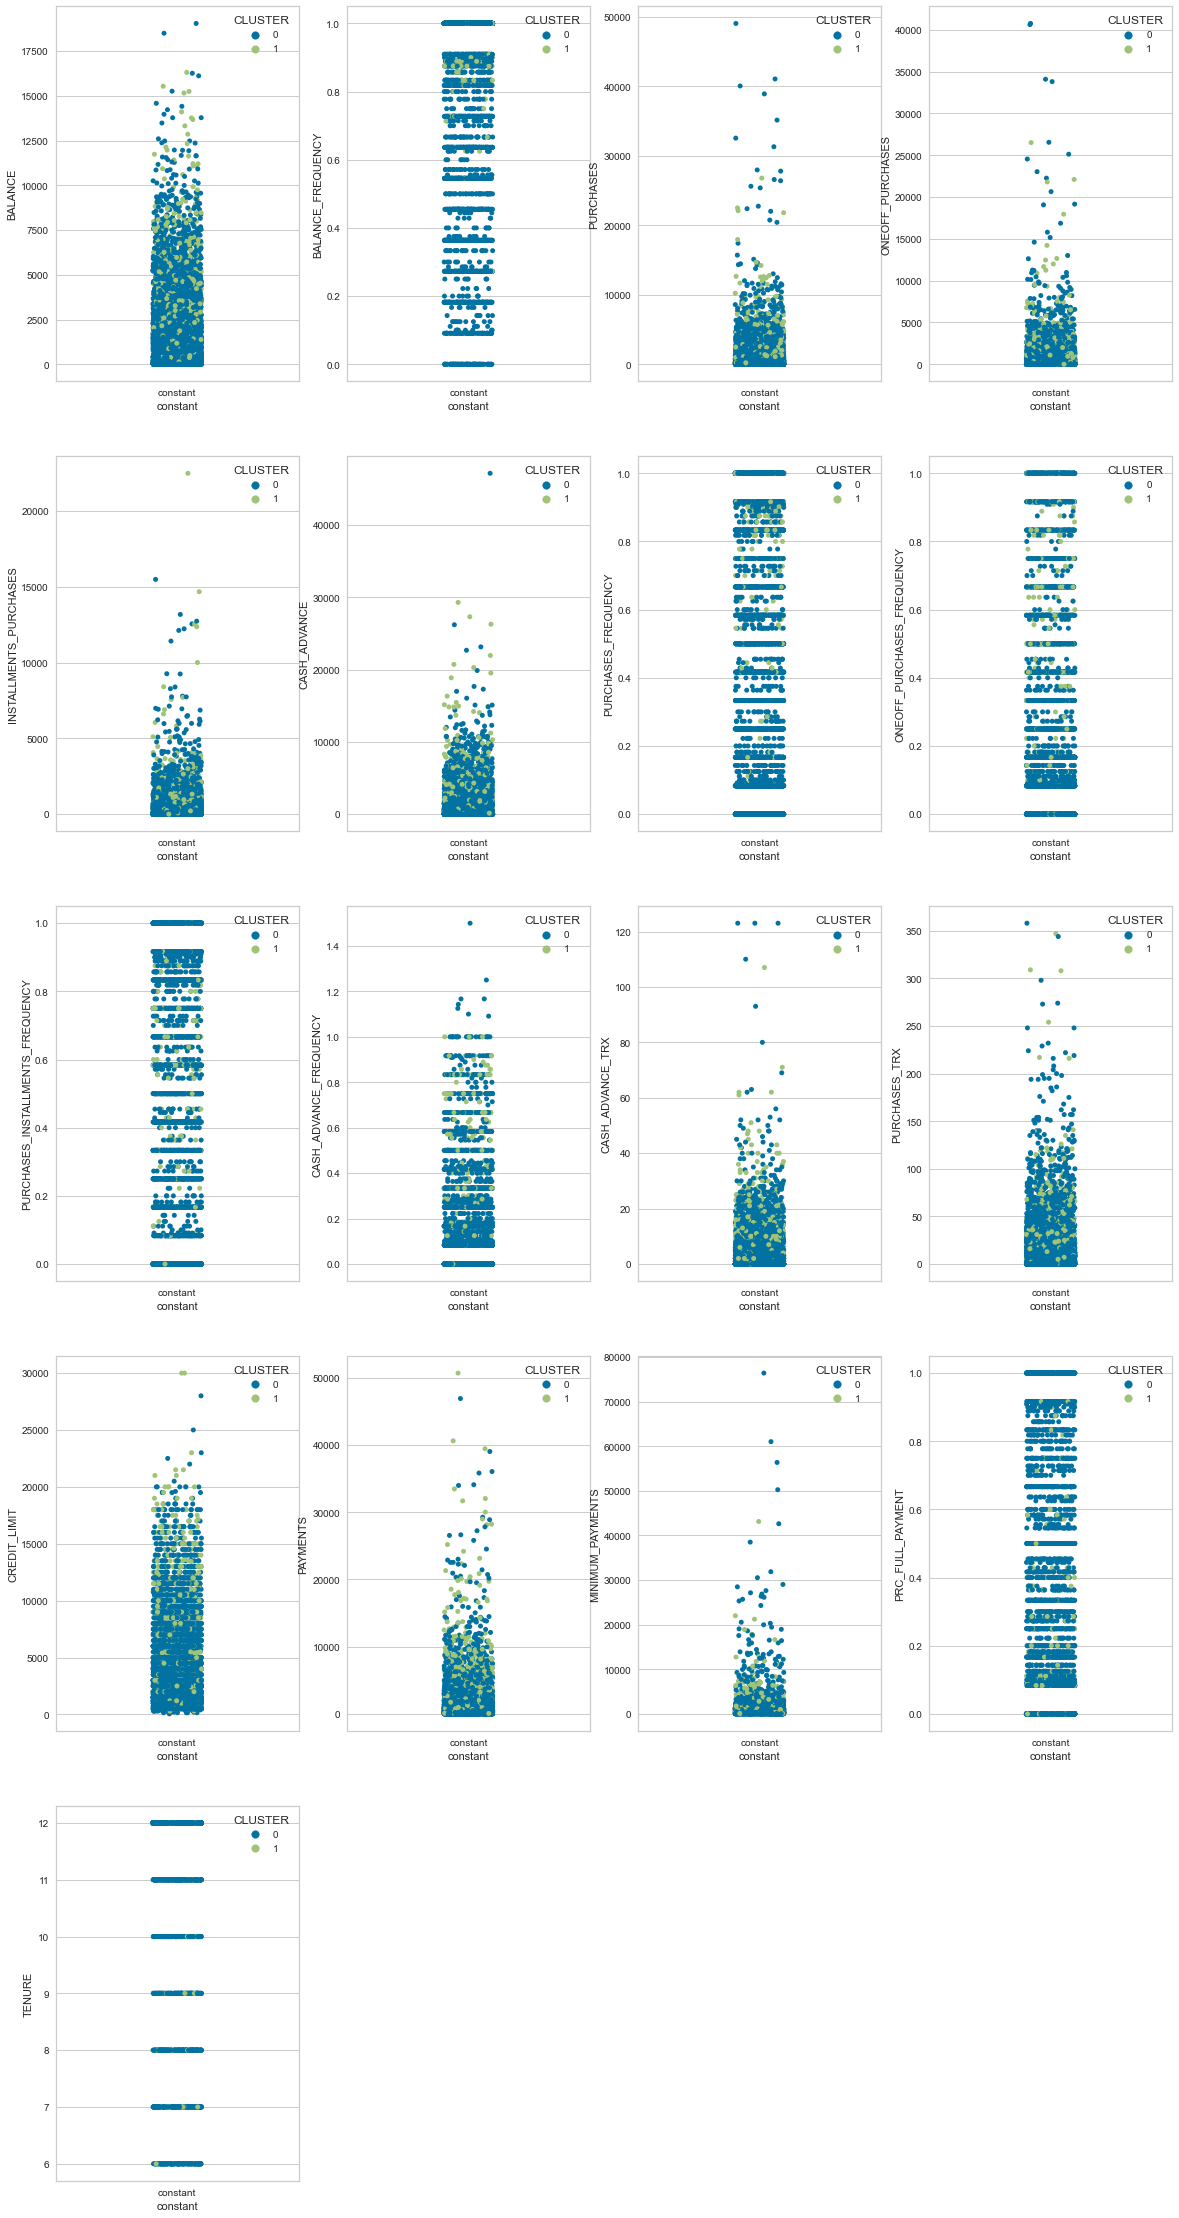

In [389]:
plt.rcParams['figure.figsize'] =(20,40)

for num in range(0,17):
    ax = plt.subplot(5,4,num+1)
    col = df_db.columns[num]
    sns.stripplot(df_db['constant'],df_db[col], ax=ax, hue=df_db['CLUSTER'])
    plt.xlabel('constant')

- `Dengan pembagian hanya pada dua cluster, terlihat susah untuk membedakan ciri khas dari keduanya`
- `hal ini disebabkan karena DBSCAN memang hanya digunakan untuk meng-cluster-kan dua fitur saja`

Text(0, 0.5, 'Purchases')

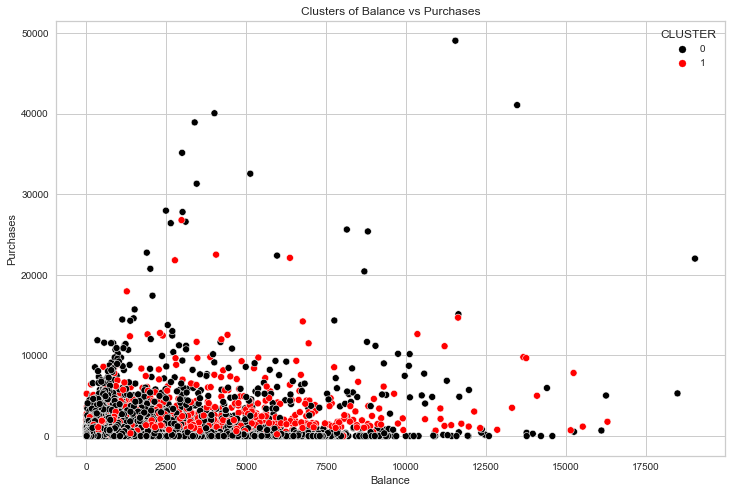

In [390]:
plt.rcParams['figure.figsize'] = (12,8)
sns.scatterplot(df_db['BALANCE'],df_db['PURCHASES'], hue=df_db['CLUSTER'], palette=['black', 'red'])
plt.title('Clusters of Balance vs Purchases')
plt.xlabel('Balance')
plt.ylabel('Purchases')

`pada plot ini juga kedua cluster masih terlihat mirip atau serupa`

# 6. Model Inference

In [391]:
df

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,312.343947,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,312.343947,0.000000,6
8947,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [392]:
from random import random
from random import randint
from random import uniform
from random import choice
# import random

In [537]:
from random import choice
da_bar = []
for i in df.columns:
    pilihan = choice(df[i].unique())
    da_bar.append(pilihan)


In [523]:
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [540]:
mod_in = pd.DataFrame(da_bar).transpose()
mod_in.columns= df.columns

In [548]:
pipe2.predict(mod_in)

array([3])

`data baru berada pada cluster`

# 7. Pengambilan Kesimpulan

## 7.1 EDA Analysis

- 78.45% user memiliki saldo kurang dari $2500 di CC mereka
#
- 76.39% sering mengisi ulang saldo mereka
#
- ada 22.82% user tidak menggunakan CC mereka selama 6 bulan terakhir
***
- 20.94 % user melakukan transaksi hanya dengan metode kas/kontan tanpa melakukan cicilan
#
- 25.25 % user melakukan transaksi hanya dengan metode tanpa melakukan cicilan kas/kontan
#
- 30.99 % user melakukan transaksi dengan metode gabungan antara cicilan dan kas/kontan
#
- 22.82 % user melakukan tidak melakukan transaksi dengan metode gabungan antara cicilan dan kas/kontan
***
- 51.71 % user melakukan transaksi dengan pembayaran dimuka (DP)
#
- 40.78% user jarang melakukan transaksi dan 30.11% user sering melakukan transaksi
#
- 74.73 % user jarang (0.0 - 0.2) melakukan transaksi dengan metode kas / kontan
#
- 53.81 % user jarang (0.0 - 0.2) melakukan transaksi dengan metode cicilan
#
- 81.58 % user jarang (0.0 - 0.2) melakukan transaksi dengan pembayaran dimuka (DP)
#
- 51.71 % user tidak pernah melakukan pembayaran dengan uang muka (DP)
#
- 77.16 % user setidaknya pernah melakukan satu transaksi selama 6 bulan terakhir dengan kartu kredit
***
- limit minimum kartu kredit yang dimiliki user adalah 50.0 dollar
#
- limit maksimum kartu kredit yang dimiliki user adalah 30000.0 dollar
#
- limit rata-rata kartu kredit yang dimiliki user adalah 4494.45 dollar
#
- limit kartu kredit terbanyak yang dimiliki user adalah 3000.0 dollar, dengan total user sebanyak 784.0 orang
***
- 2.68 % user tidak memiliki tagihan pembayaran kartu kredit
#
- 97.32 % user memiliki tagihan pembayaran kartu kredit
#
- tagihan pembayaran tertinggi adalah 50721.48 dollar
#
- rata-rata tagihan pembayaran adalah 1733.14 dollar
***
- 3.5 % user tidak memiliki minimum tagihan pembayaran kartu kredit
#
- 96.5 % user memiliki minimum tagihan pembayaran kartu kredit
#
- minimum tagihan pembayaran tertinggi adalah 76406.21 dollar
#
- rata-rata minimum tagihan pembayaran adalah 864.21 dollar
***
- 65.96 %  user tidak melakukan pembayaran tagihan
#
- persentase user dengan tenor 12 bulan ada sebanyak 84.74 %
***
- ONEOFF PURCHASE dengan PURCHASES (0.92)
# 
    PURCHASES akan meningkat jika lebih banyak user yang membeli dengan methode ONEOFF PURCHASE
- PURCHASES INSTALLMENTS FREQUENCY dengan PURCHASES FREQUENCY (0.86)
#
    PURCHASES FREQUENCY akan meningkat jika lebih frekuensi dari PURCHASES INSTALLMENTS FREQUENCY meningkat 
- CASH ADVANCE FREQUENCY dengan CASH ADVANCE TRANSACTION (0.80)
#
    CASH ADVANCE TRANSACTION akan meningkat jika frekuensi dari CASH ADVANCE FREQUENCY
- FULL PAYMENT dengan BALANCE (-0.32)
#
    jika BALANCE tinggi atau jika saldo isinya banyak, maka kecenderungan orang untuk melakukan FULL PAYMENT menurun
- CASH ADVANCE FREQUENCY dengan PURCHASE FREQUENCY (-0.31)
#
    jika CASH ADVANCE FREQUENCY meningkat maka PURCHASE FREQUENCY akan menurun

## 7.2 Model Analysis

Ada 4 Jenis model yang digunakan pada case study ini, yaitu:

1. K-Means                  (Optimum K = 7)
2. Gaussian Mixture         (Optimum K = 4)
3. Agglomerative Clustering (Optimum K = 7)
3. Model DBSCAN             (Optimum K = 2)

- Model dengan 7 cluster merupakan model yang paling optimal karena mampu membagi model secara terperici, sehingga strategy marketing yang akan diaplikasikan akan lebih tepat sasaran.
- sedangkan model dengan 4 cluster sudah tergolong baik, karena mampu membagi user berdasarkan perilakunya.
- untuk model dengan 2 cluster yaitu DBSCAN memang tidak cocok digunakan pada study kasus ini, sehingga pembagian cluster tidak tidak optimal

## 7.3 Overall Analysis
- Model yang paling optimal adalah model K Means dan Agglomerative Clustering dengan jumlah cluster ada 7.
- Conclusion pada kedua model ini sama
- Berdasarkan kedua model,
    - Cluters 1 adalah cluster yang paling optimal untuk melakukan marketing, karena cluster ini mempunyai balance yang tinggi dan juga royal serta boros, selain itu cluster ini memiliki limit kredit yang bisa dibilang tinggi serta biasanya membayar dengan full payment
    - sedangkan Cluster 5 adalah cluster yang sulit untuk pengaplikasian strategi marketing, karena cluster ini memiliki balance yang rendah dan jarang berbelanja serta tidak belanja barang mewah, serta jarang melakukan full payment serta memiliki limit credit yang rendah